In [ ]:
"""Facebook Friendship Network Analysis and Link Prediction

This notebook analyzes the SNAP Facebook friendship network and builds several
models to predict whether an edge (friendship) exists between two users.

Main components:
1. Network construction and exploratory analysis (degree, clustering, small-world properties)
2. Feature engineering for link prediction
3. Baseline heuristics and latent factor model (SVD)
4. Supervised models: Logistic Regression (Jaccard only + full features) and Gradient Boosting
5. Evaluation using AUC, Average Precision, and summary metrics
"""

0. Setting up Imports and Data Upload

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving facebook.tar.gz to facebook.tar.gz


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier

1. Data Loading and Netweork Constuction

In [ ]:
"""Process:
- Load the edge list into a pandas DataFrame.
- Build an adjacency list (Python `defaultdict(set)`) for efficient
  neighborhood queries.
- Construct an undirected edge set for fast membership tests.
- Compute basic network statistics: number of nodes and edges.
"""

In [ ]:
df= pd.read_csv('facebook_combined.txt.gz', compression='gzip', sep=' ', header=None)
print(df.head(10))

   0   1
0  0   1
1  0   2
2  0   3
3  0   4
4  0   5
5  0   6
6  0   7
7  0   8
8  0   9
9  0  10


In [ ]:
edges = df.rename(columns={0: 'u', 1: 'v'})

print(edges.head())
print(edges.info())

   u  v
0  0  1
1  0  2
2  0  3
3  0  4
4  0  5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88234 entries, 0 to 88233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u       88234 non-null  int64
 1   v       88234 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB
None


In [ ]:
# Building adjacency list
adj = defaultdict(set)
for u, v in edges[['u', 'v']].itertuples(index=False):
    adj[u].add(v)
    adj[v].add(u)

nodes = list(adj.keys())
n_nodes = len(nodes)
n_edges = len(edges)

print(f'Number of nodes: {n_nodes}')
print(f'Number of edges: {n_edges}')


Number of nodes: 4039
Number of edges: 88234


In [ ]:
# Building an undirected edge set
edge_set = set()
for _, row in edges.iterrows():
    u, v = int(row['u']), int(row['v'])
    if u == v:
        continue
    e = (min(u, v), max(u, v))
    edge_set.add(e)

2. Degree Distribution

In [ ]:
"""We compute the degree (number of friends) of each user and summarize the
distribution:

- Mean and median degree
- Minimum and maximum degree
- Approximate power-law behavior using a log–log linear fit

We expect a heavy right-skewed distribution, where most users have a
moderate number of friends, and a few users act as high-degree hubs.
"""
# degree distribution
degrees = {u: len(adj[u]) for u in nodes}
degree_array = np.array([degrees[u] for u in nodes])

print(f"Degree: mean={np.mean(degree_array)}, "
      f"max={max(degree_array)}, min={min(degree_array)}")

# Clustering coefficients
def compute_clustering_coefficient(adj):
    clustering = {}
    for u, neighbors in adj.items():
        k = len(neighbors)
        if k < 2:
            clustering[u] = 0.0
            continue

        neigh_list = list(neighbors)
        triangles = 0
        for i in range(len(neigh_list)):
            vi = neigh_list[i]
            for j in range(i + 1, len(neigh_list)):
                vj = neigh_list[j]
                if vj in adj[vi]:
                    triangles += 1
        clustering[u] = (2 * triangles) / (k * (k - 1))
    return clustering

clustering_coeffs = compute_clustering_coefficient(adj)
clustering_values = list(clustering_coeffs.values())
print(f"Clustering: mean={np.mean(clustering_values)}")
print(f"Clustering: median={np.median(clustering_values)}")

Degree: mean=43.69101262688784, max=1045, min=1
Clustering: mean=0.6055467186200862
Clustering: median=0.6


In [ ]:

# Degree array
degree_array = np.array([len(adj[u]) for u in nodes])

#  Degree stats
deg_mean  = np.mean(degree_array)
deg_median = np.median(degree_array)
deg_max   = np.max(degree_array)
deg_min   = np.min(degree_array)

print("Degree stats:")
print(f'mean   = {deg_mean}')
print(f'median = {deg_median}')
print(f'max    = {deg_max}')
print(f'min    = {deg_min}')

# log-log regression for the power law
unique_degrees, degree_counts = np.unique(degree_array, return_counts=True)
mask = unique_degrees > 0

log_deg   = np.log10(unique_degrees[mask])
log_count = np.log10(degree_counts[mask])

slope, intercept, r_value, _, _ = stats.linregress(log_deg, log_count)

print("\nPower-law fit (log-log):")
print(f"  gamma (exponent) ≈ {-slope:.2f}")
print(f"  R^2              ≈ {r_value**2:.3f}")


"""We compute the local clustering coefficient for every node:

- Clustering measures how likely it is that a user's friends are connected
  to each other.
- High clustering indicates strong triadic closure and community structure.

We also examine clustering by degree bin to understand how local cohesion
varies between low- and high-degree users.
"""
# clustering coefficients for each node
def compute_clustering_coefficient(adj):
    clustering = {}
    for u, neighbors in adj.items():
        k = len(neighbors)
        if k < 2:
            clustering[u] = 0.0
            continue

        neigh_list = list(neighbors)
        triangles = 0
        for i in range(len(neigh_list)):
            vi = neigh_list[i]
            for j in range(i + 1, len(neigh_list)):
                vj = neigh_list[j]
                if vj in adj[vi]:
                    triangles += 1
        clustering[u] = (2 * triangles) / (k * (k - 1))
    return clustering

clustering_coeffs = compute_clustering_coefficient(adj)
clustering_values = np.array(list(clustering_coeffs.values()))

print("\nClustering stats:")
print(f"  mean   = {clustering_values.mean():.4f}")
print(f"  median = {np.median(clustering_values):.4f}")

# cluster by degree
degree_bins  = [0, 10, 20, 50, 100, 200, degree_array.max() + 1]
bin_labels   = ['1–10', '11–20', '21–50', '51–100', '101–200', '200+']
avg_clustering_by_bin = []

for i in range(len(degree_bins) - 1):
    nodes_in_bin = [n for n in nodes
                    if degree_bins[i] < degrees[n] <= degree_bins[i+1]]
    if nodes_in_bin:
        vals = [clustering_coeffs[n] for n in nodes_in_bin]
        avg_clustering_by_bin.append(np.mean(vals))
    else:
        avg_clustering_by_bin.append(0.0)

print("\nAvg clustering by degree bin:")
for label, val in zip(bin_labels, avg_clustering_by_bin):
    print(f"  {label}: {val:.4f}")


Degree stats:
mean   = 43.69101262688784
median = 25.0
max    = 1045
min    = 1

Power-law fit (log-log):
  gamma (exponent) ≈ 1.18
  R^2              ≈ 0.809

Clustering stats:
  mean   = 0.6055
  median = 0.6000

Avg clustering by degree bin:
  1–10: 0.7182
  11–20: 0.6174
  21–50: 0.5439
  51–100: 0.5277
  101–200: 0.6273
  200+: 0.4630


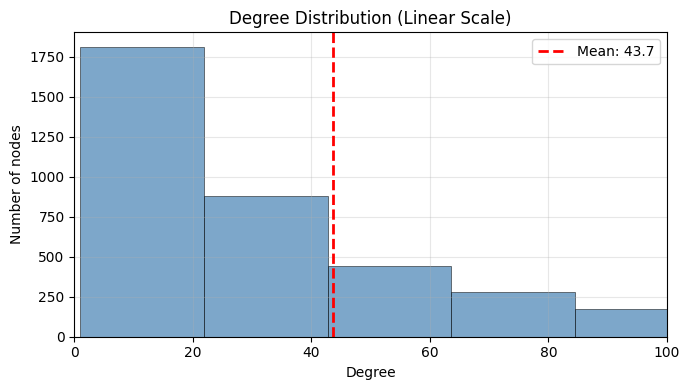

In [ ]:
# Linear degree distribution
plt.figure(figsize=(7,4))
plt.hist(degree_array, bins=50, color='steelblue',
         alpha=0.7, edgecolor='black', linewidth=0.5)
plt.axvline(deg_mean, color='red', linestyle='--',
            linewidth=2, label=f'Mean: {deg_mean:.1f}')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree Distribution (Linear Scale)')
plt.xlim(0, min(100, deg_max))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
"""## Degree Distribution (Linear Scale)

- The degree distribution is heavily right skewed; the mean (~43.7) is greater
  than the median, indicating a long right tail.
- Most users (nodes) have roughly between 5 and 25 friends (degree), while
  relatively few users have degrees approaching or exceeding 100.
- This histogram focuses on the 0–100 range so that the main structure of
  the distribution is visible without being compressed by a small number
  of high-degree hubs.
"""

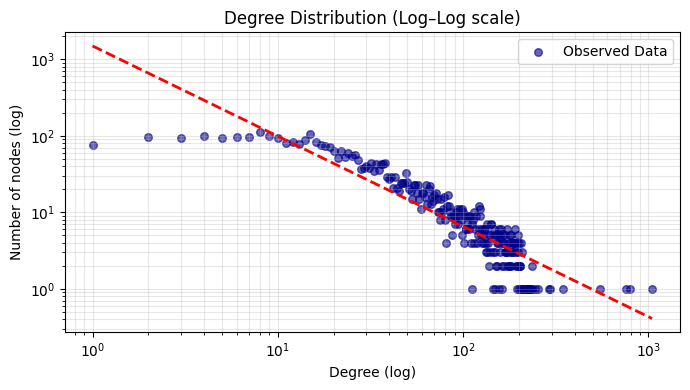

In [ ]:
# log-log degree distribution
plt.figure(figsize=(7,4))

# scatter of empirical counts
plt.scatter(unique_degrees[mask], degree_counts[mask],
            alpha=0.6, s=30, c='darkblue', label='Observed Data')

#  fit line
x_fit = np.logspace(0, np.log10(unique_degrees.max()), 100)
y_fit = 10**intercept * x_fit**slope
plt.plot(x_fit, y_fit, 'r--', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log)')
plt.ylabel('Number of nodes (log)')
plt.title('Degree Distribution (Log–Log scale)')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()


In [ ]:
"""
## Degree Distribution (Log–Log Scale)

- On log–log axes, the degree distribution is approximately linear, supporting
  a power-law-like heavy tail.
- Most users have few friends, while a small number of users have very many
  friends and act as hubs.
- The log–log transformation makes the tail behavior clearer and easier to
  compare to theoretical scale-free models.
"""

In [ ]:
# clustering by degree for clustering distribution
degree_bins  = [0, 10, 20, 50, 100, 200, degree_array.max() + 1]
bin_labels   = ['1–10', '11–20', '21–50', '51–100', '101–200', '200+']
avg_clustering_by_bin = []

for i in range(len(degree_bins) - 1):
    nodes_in_bin = [n for n in nodes
                    if degree_bins[i] < degrees[n] <= degree_bins[i+1]]
    if nodes_in_bin:
        vals = [clustering_coeffs[n] for n in nodes_in_bin]
        avg_clustering_by_bin.append(np.mean(vals))
    else:
        avg_clustering_by_bin.append(0.0)

print("\nAvg clustering by degree bin:")
for label, val in zip(bin_labels, avg_clustering_by_bin):
    print(f"  {label}: {val:.4f}")


Avg clustering by degree bin:
  1–10: 0.7182
  11–20: 0.6174
  21–50: 0.5439
  51–100: 0.5277
  101–200: 0.6273
  200+: 0.4630


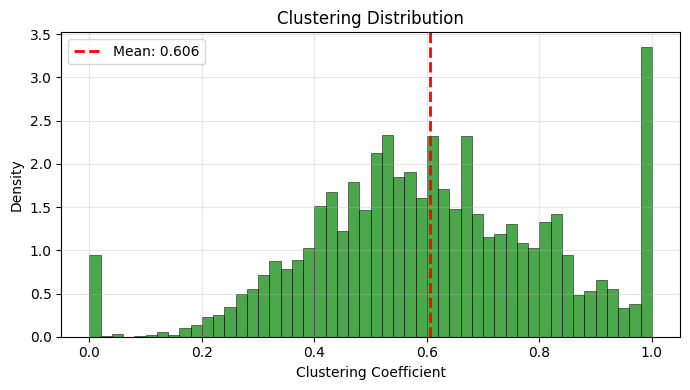

In [ ]:
# clustering distribution
plt.figure(figsize=(7,4))
plt.hist(clustering_values, bins=50, density=True,
         color='green', alpha=0.7,
         edgecolor='black', linewidth=0.5)
plt.axvline(clustering_values.mean(), color='red',
            linestyle='--', linewidth=2,
            label=f'Mean: {clustering_values.mean():.3f}')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Density')
plt.title('Clustering Distribution')
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
"""
## Clustering Distribution

- Most users have high clustering (roughly 0.4–0.8), with an average around
  0.606, meaning that a user's friends often know each other.
- Some nodes have clustering close to 1.0, indicating tightly-knit groups
  where nearly every friend is connected to every other friend.
- Combined with the short path lengths (not shown here but observed via BFS),
  this supports the **small-world** characterization of the Facebook network.
"""

4. Helper Functions &Feature Engineering for Link Prediction

In [ ]:
""" We cast link prediction as a binary classification problem:

- Positive examples: existing edges (friendships).
- Negative examples: random non-edges sampled from pairs with no connection.

We define:
- A function to sample negative pairs (non-edges).
- Structural similarity functions: Common Neighbors, Jaccard, Cosine,
  and a degree-based Correlation.
- Feature constructors for Logistic Regression and Gradient Boosting.
"""

# negative pairs
def sample_non_edges(num_samples, seed=42):
  random.seed(seed)
  non_edges = set()

  while len(non_edges) < num_samples:
    u = random.choice(nodes)
    v = random.choice(nodes)

    if u == v:
      continue
    e = (min(u,v), max(u,v))

    if e not in edge_set and e not in non_edges:
      non_edges.add(e)

  return list(non_edges)

# feature extraction functions

def common_neighbors(u, v, adj):
  return len(adj[u] & adj[v])

def jaccard_similarity(u, v, adj):
  inter = len(adj[u] & adj[v])
  union = len(adj[u] | adj[v])
  return inter / union if union > 0 else 0.0

def cosine_similarity(u, v, adj):
  num = len(adj[u] & adj[v])
  denom = (len(adj[u]) ** 0.5) * (len(adj[v]) ** 0.5)
  return num / denom if denom > 0 else 0.0

def correlation_similarity(u, v, adj):
  cu = len(adj[u])
  cv = len(adj[v])
  inter = len(adj[u] & adj[v])
  if cu == 0 or cv == 0:
    return 0
  mean_u = cu / len(adj)
  mean_v = cv / len(adj)
  num = inter - mean_u * mean_v * len(adj)
  denom = np.sqrt((cu - mean_u**2 * len(adj)) * (cv - mean_v**2 * len(adj)))
  return num / denom if denom > 0 else 0.0



# for logistic regression
def pair_features(u, v):
  neigh_u = adj[u]
  neigh_v = adj[v]
  deg_u = len(neigh_u)
  deg_v = len(neigh_v)

  common = len(neigh_u & neigh_v)
  union = len(neigh_u | neigh_v)
  jaccard = common / union if union > 0 else 0.0

  return [deg_u, deg_v, common, jaccard]

# for gradiant boosting
def compute_features(u, v, adj):
  return np.array([
      common_neighbors(u, v, adj),
      jaccard_similarity(u, v, adj),
      cosine_similarity(u, v, adj),
      correlation_similarity(u, v, adj)
  ])


5. Dataset Builders for training and evaluation

In [ ]:
"""We construct balanced datasets of positive and negative node pairs:

- **Logistic Regression**
  - Uses feature vectors built from degrees, common neighbors, and Jaccard.
  - Data is split into training and validation sets.

- **Common Neighbors**
  - No training is required; we only need labeled pairs and their scores.

These datasets are later reused for SVD and Gradient Boosting evaluation.
"""
# Dataset for logistic regression
def build_lr_dataset(num_pos=5000, seed=42):
    random.seed(seed)
    pos_edges = random.sample(list(edge_set), num_pos)
    neg_edges = sample_non_edges(num_pos, seed=seed)

    X_pairs = []
    y_pairs = []

    for (u, v) in pos_edges:
        X_pairs.append(pair_features(u, v))
        y_pairs.append(1)

    for (u, v) in neg_edges:
        X_pairs.append(pair_features(u, v))
        y_pairs.append(0)

    X_pairs = np.array(X_pairs)
    y_pairs = np.array(y_pairs)

    X_train, X_val, y_train, y_val = train_test_split(
        X_pairs, y_pairs, test_size=0.2, random_state=42, stratify=y_pairs
    )
    return X_train, X_val, y_train, y_val

# Dataset for common neighbors evaluation
def make_link_dataset_cn(n_pos=10000, n_neg=10000, seed=42):
    random.seed(seed)

    edges_list = []
    for u in adj:
        for v in adj[u]:
            if u < v:
                edges_list.append((u, v))

    pos = random.sample(edges_list, min(n_pos, len(edges_list)))

    neg = set()
    while len(neg) < n_neg:
        u = random.choice(nodes)
        v = random.choice(nodes)
        if u == v:
            continue
        if v not in adj[u]:
            neg.add((min(u, v), max(u, v)))
    neg = list(neg)

    pairs = pos + neg
    labels = np.array([1]*len(pos) + [0]*len(neg))
    return pairs, labels

6. Logistic Regression Models

In [ ]:
"""We consider two Logistic Regression models:

1. **LR (Jaccard only)**:
   Uses only the Jaccard similarity as a feature. This tests how strong
   a single structural similarity metric can be.

2. **LR (Full features)**:
   Uses degree(u), degree(v), common neighbors, and Jaccard similarity.
   This serves as a more expressive linear baseline for link prediction.
"""
all_results = {}

# Baseline 1: Logistic Regression (jaccard)
X_train_p, X_val_p, y_train_p, y_val_p = build_lr_dataset(num_pos=5000)

X_train_j = X_train_p[:, -1].reshape(-1, 1)
X_val_j = X_val_p[:, -1].reshape(-1, 1)

log_reg_j = LogisticRegression(max_iter=1000)
log_reg_j.fit(X_train_j, y_train_p)

y_prob_j = log_reg_j.predict_proba(X_val_j)[:, 1]
y_pred_j = (y_prob_j >= 0.5).astype(int)

results_lr_j = {
    'accuracy': accuracy_score(y_val_p, y_pred_j),
    'auc': roc_auc_score(y_val_p, y_prob_j),
    'ap': average_precision_score(y_val_p, y_prob_j),
    'y_true': y_val_p,
    'y_prob': y_prob_j
}
print('\nBaseline 1:')
print(f"AUC: {results_lr_j['auc']}",
      f"AP: {results_lr_j['ap']}",
      f"Accuracy: {results_lr_j['accuracy']}")


# MODEL 1: Logistic Regression (Full features)
log_reg_full = LogisticRegression(max_iter=1000)
log_reg_full.fit(X_train_p, y_train_p)

y_prob_full = log_reg_full.predict_proba(X_val_p)[:, 1]
y_pred_full = (y_prob_full >= 0.5).astype(int)

results_lr_full = {
    'accuracy': accuracy_score(y_val_p, y_pred_full),
    'auc': roc_auc_score(y_val_p, y_prob_full),
    'ap': average_precision_score(y_val_p, y_prob_full),
    'y_true': y_val_p,
    'y_prob': y_prob_full
}
print('\nModel 1:')
print(f"AUC: {results_lr_full['auc']}",
      f"AP: {results_lr_full['ap']}",
      f"Accuracy: {results_lr_full['accuracy']}")



# Baseline 2: SVD/Matrix Factorization
"""We implement a simple latent factor model:

- Construct the adjacency matrix A.
- Compute a low-rank approximation using Truncated SVD with k = 10.
- Use the dot product of node embeddings as a link score.

This approach captures communities and global structure but tends to perform
worse than local similarity-based features for this task.
"""
def fast_latent_factor_model(adj, k=10):
    nodes_sorted = sorted(adj.keys())
    idx = {node: i for i, node in enumerate(nodes_sorted)}
    n = len(nodes_sorted)

    A = np.zeros((n, n))
    for u in adj:
        for v in adj[u]:
            A[idx[u], idx[v]] = 1

    svd = TruncatedSVD(n_components=k, random_state=42)
    U = svd.fit_transform(A)
    V = U.copy()
    return U, V, idx, nodes_sorted

U, V, idx_lfm, nodes_sorted = fast_latent_factor_model(adj, k=10)

# Evaluate SVD
def build_lfm_eval_data(n_positive=10000, n_negative=10000):
    random.seed(42)

    edges_list = [(u, v) for u in adj for v in adj[u] if u < v]
    n_pos = min(n_positive, len(edges_list))
    pos_samples = random.sample(edges_list, n_pos)

    neg_samples = []
    while len(neg_samples) < n_negative:
        u = random.choice(nodes_sorted)
        v = random.choice(nodes_sorted)
        if u != v and v not in adj[u]:
            pair = (u, v) if u < v else (v, u)
            if pair not in neg_samples:
                neg_samples.append(pair)

    scores = []
    labels = []

    for (u, v) in pos_samples:
        iu, iv = idx_lfm[u], idx_lfm[v]
        scores.append(float(np.dot(U[iu], V[iv])))
        labels.append(1)

    for (u, v) in neg_samples:
        iu, iv = idx_lfm[u], idx_lfm[v]
        scores.append(float(np.dot(U[iu], V[iv])))
        labels.append(0)

    return np.array(scores), np.array(labels)

scores_lfm, labels_lfm = build_lfm_eval_data()

results_svd = {
    'accuracy': accuracy_score(labels_lfm, (scores_lfm >= np.median(scores_lfm)).astype(int)),
    'auc': roc_auc_score(labels_lfm, scores_lfm),
    'ap': average_precision_score(labels_lfm, scores_lfm),
    'y_true': labels_lfm,
    'y_prob': scores_lfm
}
print('\nBaseline 2:')
print(f"AUC: {results_svd['auc']}",
      f"AP: {results_svd['ap']}",
      f"Accuracy: {results_svd['accuracy']}")



# Baseline 3: Common Neighbors
"""This classic heuristic uses only the number of shared friends:

- Score(u, v) = |Γ(u) ∩ Γ(v)|

No training is required. We simply compute scores and evaluate how well
this heuristic ranks true edges above sampled non-edges.
"""
pairs_cn, labels_cn = make_link_dataset_cn(n_pos=10000, n_neg=10000)
scores_cn = np.array([common_neighbors(u, v, adj) for (u, v) in pairs_cn])

results_cn = {
    'accuracy': accuracy_score(labels_cn, (scores_cn > 0).astype(int)),
    'auc': roc_auc_score(labels_cn, scores_cn),
    'ap': average_precision_score(labels_cn, scores_cn),
    'y_true': labels_cn,
    'y_prob': scores_cn
}
print('\nBaseline 3:')
print(f"AUC: {results_cn['auc']}",
      f"AP: {results_cn['ap']}",
      f"Accuracy: {results_cn['accuracy']}")


# Gradient Boosting Classifier

"""We train a Gradient Boosting model on four structural similarity features:

1. Common Neighbors
2. Jaccard Similarity
3. Cosine Similarity
4. Correlation Similarity

Gradient Boosting can model nonlinear interactions and typically provides
the best overall performance among our supervised models.
"""

def create_training_data_features(n_positive=3000, n_negative=3000, seed=42):
    random.seed(seed)
    X, y = [], []

    edges_list = [(u, v) for u in adj for v in adj[u] if u < v]
    pos = random.sample(edges_list, min(n_positive, len(edges_list)))

    for u, v in pos:
        X.append(compute_features(u, v, adj))
        y.append(1)

    neg = []
    while len(neg) < n_negative:
        u = random.choice(nodes)
        v = random.choice(nodes)
        if u != v and v not in adj[u]:
            neg.append((u, v))
            X.append(compute_features(u, v, adj))
            y.append(0)

    return np.array(X), np.array(y)

X_feat, y_feat = create_training_data_features()
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_feat, y_feat, test_size=0.2, random_state=42, stratify=y_feat
)

gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
)
gb_model.fit(X_train_f, y_train_f)

y_prob_f = gb_model.predict_proba(X_test_f)[:, 1]

results_gb = {
    'accuracy': accuracy_score(y_test_f, (y_prob_f >= 0.5).astype(int)),
    'auc': roc_auc_score(y_test_f, y_prob_f),
    'ap': average_precision_score(y_test_f, y_prob_f),
    'y_true': y_test_f,
    'y_prob': y_prob_f,
    'feature_importance': gb_model.feature_importances_
}
print('\nModel 3:')
print(f"AUC: {results_gb['auc']}",
      f"AP: {results_gb['ap']}",
      f"Accuracy: {results_gb['accuracy']}")




Baseline 1:
AUC: 0.9902664999999999 AP: 0.9885344101060735 Accuracy: 0.934

Model 1:
AUC: 0.992923 AP: 0.9909575681755101 Accuracy: 0.9595

Baseline 2:
AUC: 0.94680108 AP: 0.9554959451017382 Accuracy: 0.8639

Baseline 3:
AUC: 0.993741685 AP: 0.9918710568566373 Accuracy: 0.91595

Model 3:
AUC: 0.9942152777777777 AP: 0.9933058684248983 Accuracy: 0.97


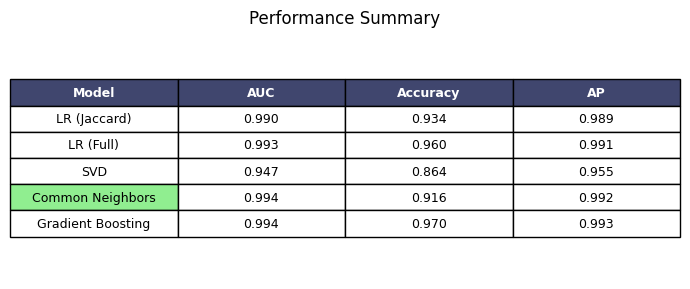

In [ ]:
"""
10. Evaluation & Model Comparison

We aggregate all model results into a dictionary and generate:

- A performance summary table (AUC, Accuracy, Average Precision).
- A bar chart comparing AUC across models.
- ROC curves for all models on the same plot.
- Precision–Recall curves for all models.
- Feature importance plot for Gradient Boosting.

These visualizations make it easy to see that:
- Gradient Boosting and Common Neighbors achieve the best AUC/AP.
- Logistic Regression (Full) is close behind.
- Jaccard-only is strong but slightly weaker.
- SVD performs noticeably worse than the other approaches.
"""

all_results = {
    'LR (Jaccard)': results_lr_j,
    'LR (Full)': results_lr_full,
    'SVD': results_svd,
    'Common Neighbors': results_cn,
    'Gradient Boosting': results_gb
}

# comparison table
fig, ax = plt.subplots(figsize=(7, 3))
ax.axis('off')

table_data = [['Model', 'AUC', 'Accuracy', 'AP']]
for name, auc, acc, ap in model_performance:
    table_data.append([name, f'{auc:.3f}', f'{acc:.3f}', f'{ap:.3f}'])

table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Header styling
for i in range(4):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best row (Common Neighbors = 4th data row → row index 4)
table[(4, 0)].set_facecolor('#90EE90')

ax.set_title('Performance Summary', pad=10)
plt.tight_layout()
plt.show()


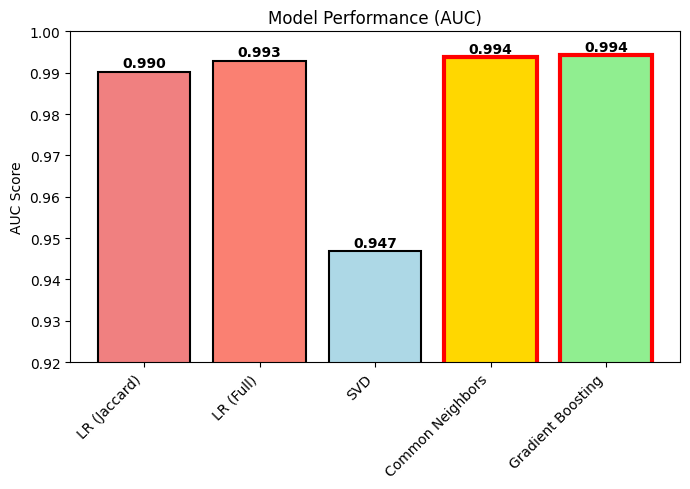

In [ ]:
models = list(all_results.keys())

aucs = [res['auc'] for res in all_results.values()]
aps = [res['ap'] for res in all_results.values()]
accs = [res['accuracy'] for res in all_results.values()]

plt.figure(figsize=(7, 5))
colors = ['lightcoral', 'salmon', 'lightblue', 'gold', 'lightgreen']

bars = plt.bar(range(len(models)), aucs, color=colors, edgecolor='black',
               linewidth=1.5)

# Highlight best models
max_auc = max(aucs)
for i, bar in enumerate(bars):
  if np.isclose(aucs[i], max_auc, atol=1e-3):
    bar.set_edgecolor('red')
    bar.set_linewidth(3)


plt.xticks(range(len(models)), models, rotation=45, ha='right')
plt.ylabel('AUC Score')
plt.title('Model Performance (AUC)')
plt.ylim([0.92, 1.0])

for i, v in enumerate(aucs):
    plt.text(i, v + 0.001, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


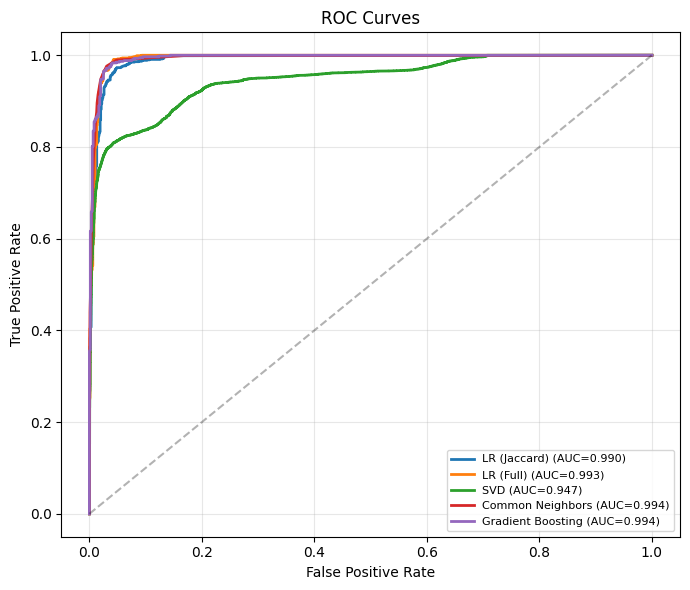

In [ ]:
# ROC Curves
plt.figure(figsize=(7, 6))
for name, res in all_results.items():
    fpr, tpr, _ = roc_curve(res['y_true'], res['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(fontsize=8, loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("eval_roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()

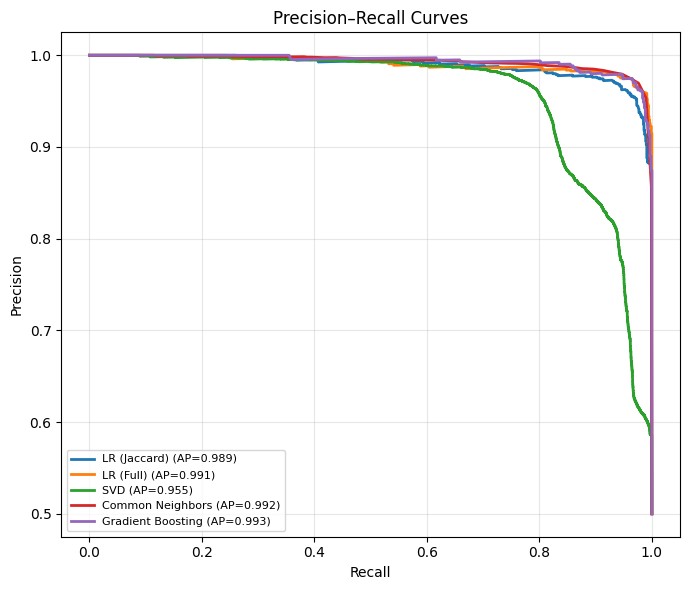

In [ ]:
# precision-recall curves
plt.figure(figsize=(7, 6))
for name, res in all_results.items():
    prec, rec, _ = precision_recall_curve(res['y_true'], res['y_prob'])
    plt.plot(rec, prec, label=f"{name} (AP={res['ap']:.3f})", linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves')
plt.legend(fontsize=8, loc='lower left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("eval_pr_curves.png", dpi=300, bbox_inches='tight')
plt.show()

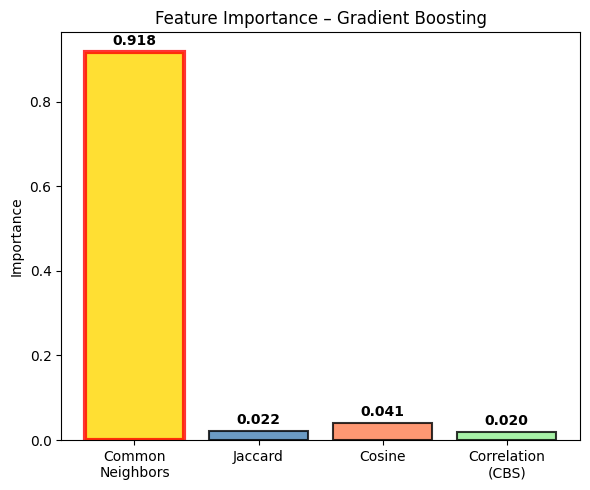

In [ ]:
# Gradient Boost Feature Importance Bar Chart

if 'Gradient Boosting' in all_results and 'feature_importance' in all_results['Gradient Boosting']:
    plt.figure(figsize=(6, 5))
    feature_names = ['Common\nNeighbors', 'Jaccard', 'Cosine', 'Correlation\n(CBS)']
    importances = all_results['Gradient Boosting']['feature_importance']

    bars = plt.bar(feature_names, importances,
                   color=['gold', 'steelblue', 'coral', 'lightgreen'],
                   edgecolor='black', linewidth=1.5, alpha=0.8)

    max_idx = np.argmax(importances)
    bars[max_idx].set_edgecolor('red')
    bars[max_idx].set_linewidth(3)

    plt.ylabel('Importance')
    plt.title('Feature Importance – Gradient Boosting')

    for bar, imp in zip(bars, importances):
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h + 0.01,
                 f'{imp:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig("eval_gb_feature_importance.png", dpi=300, bbox_inches='tight')
    plt.show()

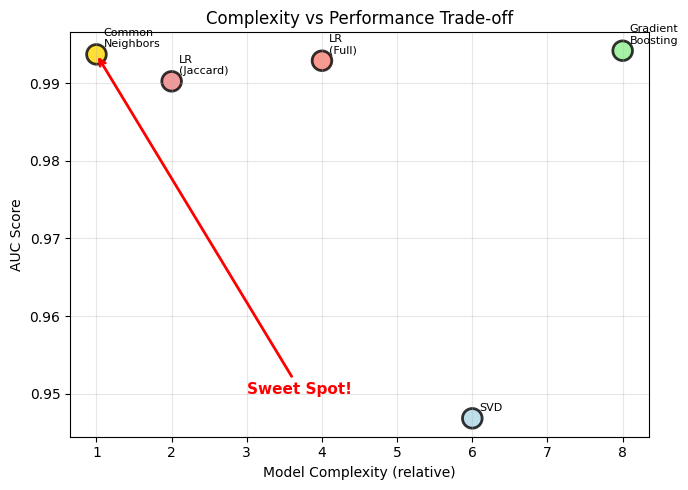

In [ ]:
""" model complexity scatter

# complexity chosen based on features, train time, parameters
# common neighbors: no train time, 1 feature---> 1
# Logistic Regression (Jaccard): 1 feature, little training---> 2
# Logistic Regression (full): multiple features, more parameters, more training
# ---> 4
# SVD: matrix factorization, lots of training ---> 6
#Gradient Boosting: many parameters, longest training time (a lot of training)
# ---> 8"""

plt.figure(figsize=(7, 5))
complexity = [2, 4, 6, 1, 8]

plt.scatter(complexity, aucs, s=200, c=colors,
            edgecolor='black', linewidth=2, alpha=0.8)

for i, name in enumerate(models):
    plt.annotate(name.replace(' ', '\n'),
                 (complexity[i], aucs[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Model Complexity (relative)')
plt.ylabel('AUC Score')
plt.title('Complexity vs Performance Trade-off')
plt.grid(True, alpha=0.3)

# Best model
plt.annotate('Sweet Spot!',
             xy=(complexity[3], aucs[3]),
             xytext=(3, 0.95),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, color='red', fontweight='bold')


plt.tight_layout()
plt.show()

In [ ]:
"""
## Evaluation Summary

**Performance Summary Table**
- Compares all models across AUC, accuracy, and average precision.
- Common Neighbors and Gradient Boosting achieve the highest AUC/AP.
- Logistic Regression with full features improves on the Jaccard-only baseline.
- The SVD Latent Factor model performs noticeably worse, so we do not
  build more complex variants on top of it.

**ROC Curves**
- Logistic Regression (Full), Common Neighbors, and Gradient Boosting
  all achieve very high AUC values (~0.993–0.994), indicating excellent
  separation between positive and negative pairs.
- Jaccard-only remains strong (AUC ≈ 0.990), while SVD lags behind
  (AUC ≈ 0.947).

**Precision–Recall Curves**
- Most models maintain extremely high precision across a wide range of recall.
- Logistic Regression (Full), Common Neighbors, and Gradient Boosting stay
  close to perfect precision until very high recall (> 0.8).
- SVD again drops off earlier, confirming it is the weakest model.

**Feature Importance - Gradient Boosting**
- Shows which features the Gradient Boosting model relied on when predicting
new edges (all similarity features).
- Common Neighbors is contributing to over 90% of the model's decision-making,
with the jaccard, cosine, and similarity correlation not even contributing 1%.
- This explains why Common Neighbors alone performs just as well as
Gradient Boosting.
- It tells us that the strongest predictive signal in this network is simply
the number of mutual friends.

**Model Performance**
- AUC scores comparison across all 5 models, where Common Neighbors and Gradient
Boosting achieve the highest performance (AUC=0.994) followed by Logistic
Regression (full), and then Logistic Regression (Jaccard). SVM performs
significantly worse, showing that latent factor approaches are less effective
for predicting local friendships within this network.
- The identical scores seen in Common Neighbors and Gradient Boosting shows that
simple similarity measures can sometimes match the effectiveness of more complex
models. But overall as a model, Gradient Boosting performs the best.


**Complexity vs. Performance Trade-off**
- Compares each model's predictive performance (AUC) against a relative
measure of model complexity based on the number of features and training time.
- The best model is Gradient Boosting, with a complexity of 8, but the best
overall method is Common Neighbors as it achieves the highest performance
while having the lowest complexity (sweet-spot). Logistic Regression
models sit closer to the middle meaning moderate complexity
with strong performance.

- SVD on the other hand has relatively high complexity but performs the worst.
- Again this confirms latent factor methods do not work best within this
social network.


Overall, the results show that model-wise, the Gradient Boosting model
outperforms the rest, however that is due to its heavy reliance on the
similarity heuristic Common Neighbors, for prediction precision. This tells us
that simple structural features are highly predictive for link formation
in the Facebook network, and even more complex models like Gradient Boosting
ultimately rely on these same features to achieve top performance.
"""

"\n## Evaluation Summary\n\n**Performance Summary Table**\n- Compares all models across AUC, accuracy, and average precision.\n- Common Neighbors and Gradient Boosting achieve the highest AUC/AP.\n- Logistic Regression with full features improves on the Jaccard-only baseline.\n- The SVD Latent Factor model performs noticeably worse, so we do not\n  build more complex variants on top of it.\n\n**ROC Curves**\n- Logistic Regression (Full), Common Neighbors, and Gradient Boosting\n  all achieve very high AUC values (~0.993–0.994), indicating excellent\n  separation between positive and negative pairs.\n- Jaccard-only remains strong (AUC ≈ 0.990), while SVD lags behind\n  (AUC ≈ 0.947).\n\n**Precision–Recall Curves**\n- Most models maintain extremely high precision across a wide range of recall.\n- Logistic Regression (Full), Common Neighbors, and Gradient Boosting stay\n  close to perfect precision until very high recall (> 0.8).\n- SVD again drops off earlier, confirming it is the weakes